In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [35]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
# Base.prepare(engine, reflect=True)
Base.prepare(autoload_with=engine)

In [36]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set.
#last_date = session.query(func.max(Measurement.date)).scalar()
# Can't decide which query I like better.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

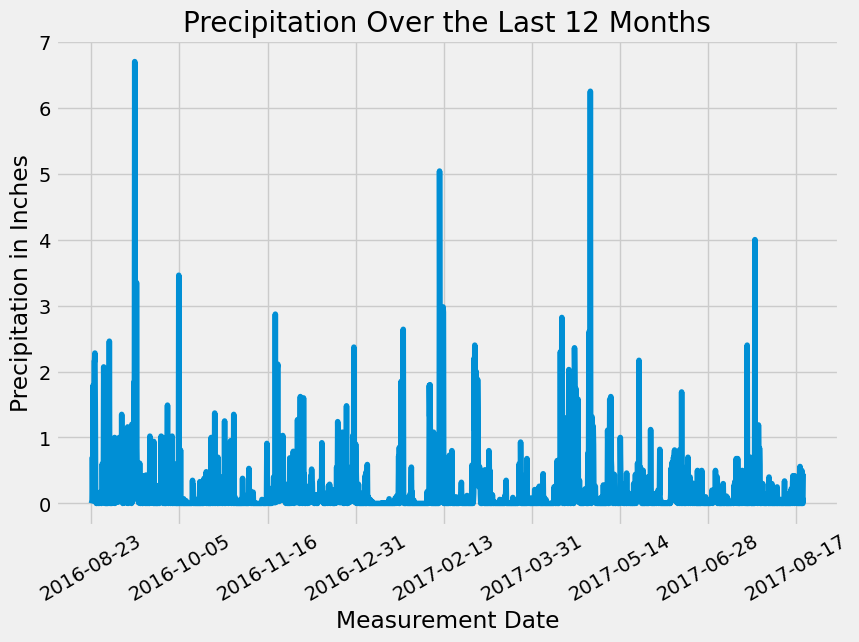

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp). \
        filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Measurement Date', 'Precipitation Amount (inches)'])

# Might as well drop some NAN
precipitation_df.dropna(axis=0, how='any', inplace= True)

# Sort the dataframe by date
precipitation_df.set_index('Measurement Date', inplace=True)
precipitation_df = precipitation_df.sort_values('Measurement Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot = 30, figsize = (9, 6), legend = False, title = 'Precipitation Over the Last 12 Months', \
ylabel = 'Precipitation in Inches', xlabel = 'Measurement Date')
plt.show()

In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation Amount (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(Measurement.station))).all()

[(9,)]

In [43]:
# Design a query to calculate the total number of stations in the dataset
columns = inspector.get_columns('station')
session.query(Station.id).count()



9

In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


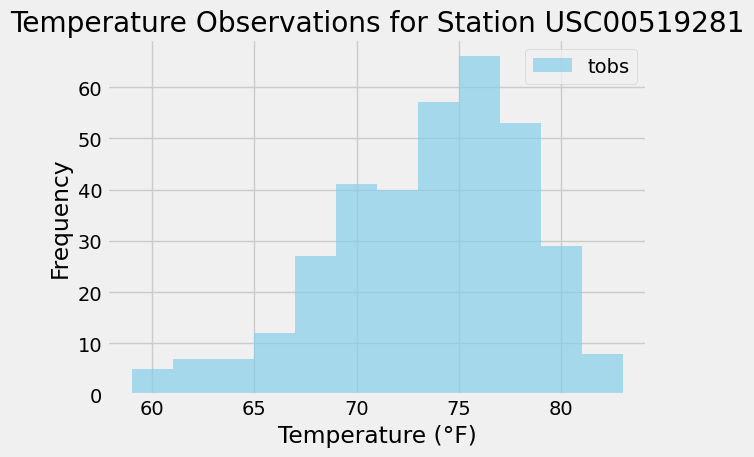

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= year_ago_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

temperatures = [result.tobs for result in station_temps]

# Create a histogram plot
plt.hist(temperatures, bins=12, color='skyblue', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station USC00519281')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [47]:
# Close Session
session.close()